In [1]:
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
# from IPython.display import display, HTML

from pykat import finesse
from pykat.commands import *
pykat.init_pykat_plotting(dpi=90)

from pprint import pprint as pprint

                                              ..-
    PyKat 1.2.2           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
def r_to_gain_in_dB(r):
    return 10*np.log10(np.exp(r))

def gain_in_dB_to_r(gain):
    return np.log(10**(gain/10))

In [3]:
# base model that holds the components, run detection models on top of this
basekat = finesse.kat()
#basekat.verbose = False

basecode = """
# no spaces in model, except inside cavity

l laser 1 0 0 nbs1 # power = 1W
bs BS 0.5 0.5 0 45 nbs1 nbs2 nbs3 nbs4 # phi = 0

s sdbs1 0 nbs4 ndbs1 # zero length space
dbs isol ndbs1 ndbs2 ndbs3 ndbs4  # dbs doesn't req R T phi alpha
s sdbs2 0 ndbs2 nc0 # zero length space

m m1 0.9 0.1 0 nc0 nc1 # R = 0.9, T = 0.1, phi = 0
s sc1 0.5 nc1 nc2 # total cavity L = 1m
nle nle1 0.05 0 nc2 nc3 # r = 0.05, sqz angle = 0
s sc2 0.5 nc3 nc4 # total cavity L = 1m
m m2 1 0 0 nc4 nc5 # R = 1, T = 0, phi = 0

# homodyne detector and quantum noise
qhd qn 180 nbs2 nbs3
fsig noise 1 # noise at 1 Hz

# by default noise enters through every open port, lossy optic, or squeezer
# -- Quantum noise inputs --
#   |- %10-.10s - laser Node LASER NOISE
#   |- %10-.10s - m2 Node OPEN PORT
#   |- %10-.10s - BS Node OPEN PORT
#   |- %10-.10s - BS Node OPEN PORT
#   |- %10-.10s - isol Node OPEN PORT
#   |- %10-.10s - isol Node OPEN PORT
# can instead specify exactly where through "vacuum" command
# vacuum isol laser
#printnoises

"""

basekat.parse(basecode)

Parsing `nle nle1 0.05 0 nc2 nc3` into pykat object not implemented yet, added as extra line.


In [4]:
pprint((basekat.components, basekat.detectors, basekat.commands))

({'BS': <pykat.components.beamSplitter_2 (BS) at 0x7f7adb533c50>,
  'isol': <pykat.components.dbs_4 (isol) at 0x7f7adb548908>,
  'laser': <pykat.components.laser_1 (laser) at 0x7f7adb533780>,
  'm1': <pykat.components.mirror_6 (m1) at 0x7f7adb54d128>,
  'm2': <pykat.components.mirror_9 (m2) at 0x7f7adb54d710>,
  'sc1': <pykat.components.space_7 (sc1) at 0x7f7b10096470>,
  'sc2': <pykat.components.space_8 (sc2) at 0x7f7adb54d320>,
  'sdbs1': <pykat.components.space_3 (sdbs1) at 0x7f7adb533978>,
  'sdbs2': <pykat.components.space_5 (sdbs2) at 0x7f7adb5487b8>},
 {'qn': <pykat.detectors.pykat.detectors.qhd_1 object at 0x7f7adb552080>},
 {})


In [5]:
kat1 = deepcopy(basekat)

kat1code = """
xaxis nle1 r lin -1 1 10000 # to spot threshold
#yaxis abs:deg
"""

kat1.parse(kat1code)

In [6]:
# pprint((kat1.components, kat1.detectors, kat1.commands))
out1 = kat1.run()
print(out1.stdout)

--------------------------------------------------------------
Running kat - Started at 2020-08-24 17:06:35.261719
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat


100% | ETA:  0:00:00 | Calculating                                             


Finished in 0.275489 seconds

------------------------------------------------------------------------
                     FINESSE 2.3.1            (build 2.3.1.11-ga3cc55b2)
       o_.-=.        Frequency domain INterferomEter Simulation SoftwarE
      (\'".\|        06.07.2020         http://www.gwoptics.org/finesse/
      .>' (_--.      
   _=/d   ,^\        Input file /tmp/tmpvy56yvvf.kat,
  ~~ \)-'   '        Output file /tmp/tmpvy56yvvf.out,
     / |             Gnuplot file /tmp/tmpvy56yvvf.gnu 
    '  '                                        Mon Aug 24 17:06:35 2020
------------------------------------------------------------------------
 
 computation time:  0.179045s



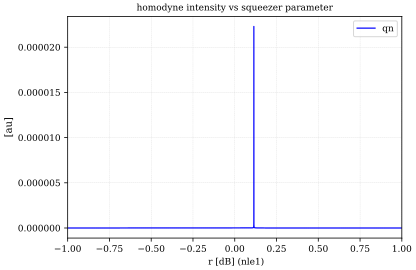

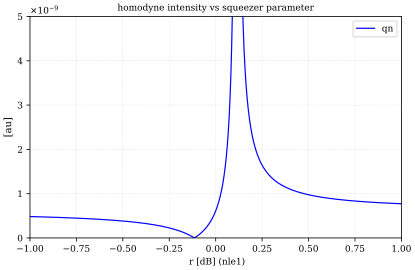

In [7]:
out1.plot(detectors=['qn'], title="homodyne intensity vs squeezer parameter")
# detectors=['qn']
out1.plot(filename='pykat_qhd_vs_r.pdf',
          title="homodyne intensity vs squeezer parameter",
          ylim=(0, 0.5*1e-8))

In [8]:
# checking limits against HomI(0)
homI_zero = out1.y[np.searchsorted(out1.x, 0)][0]
print(out1.y[0], homI_zero, out1.y[-1])

[4.83654039e-10] 6.11058157799027e-10 [7.72023062e-10]


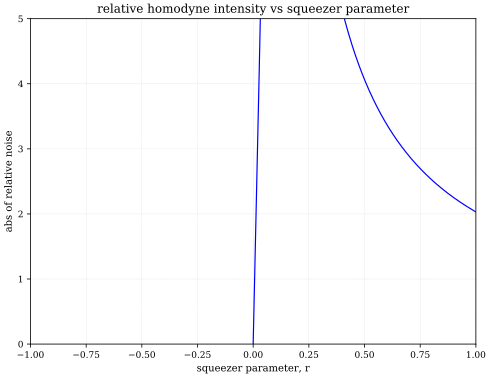

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(out1.x, 20*np.log10(out1.y/homI_zero))
ax.set_ylim(0, 5)
ax.set(title="relative homodyne intensity vs squeezer parameter",
       xlabel="squeezer parameter, r",
       ylabel="abs of relative noise")
plt.show()

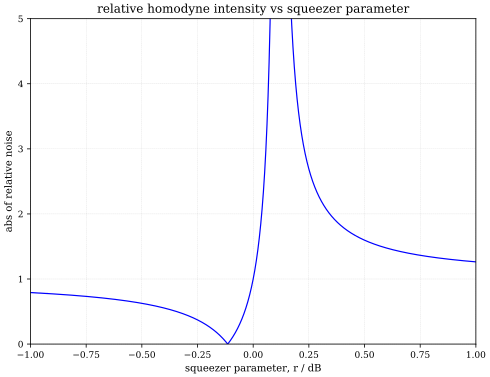

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(out1.x, out1.y/homI_zero)
ax.set_ylim(0, 5)
ax.set(title="relative homodyne intensity vs squeezer parameter",
       xlabel="squeezer parameter, r / dB",
       ylabel="abs of relative noise")
fig.savefig("pykat_relative_qhd_vs_r.pdf")
plt.show()

In [11]:
# finding threshold
print(out1.x[out1.y.argmin()], out1.x[out1.y.argmax()])
# rThresh
rT = 0.1144

-0.1144 0.1144


In [12]:
# kat3 = deepcopy(basekat)

# kat3code = """
# variable sqzr 0
# put nle1 r $sqzr

# xaxis laser f lin 0 5G 10000
# #yaxis abs:deg
# """

# kat3.parse(kat3code)

# out3 = kat3.run()

# out3.plot()

In [13]:
# a hack: want to set r param but isn't co-operating, so hard code everything again
hackbase = finesse.kat()
hackbase.verbose = False

hackbasecode = """
l laser 1 0 0 nbs1 # power = 1W
bs BS 0.5 0.5 0 45 nbs1 nbs2 nbs3 nbs4 # phi = 0

s sdbs1 0 nbs4 ndbs1 # zero length space
dbs isol ndbs1 ndbs2 ndbs3 ndbs4  # dbs doesn't req R T phi alpha
s sdbs2 0 ndbs2 nc0 # zero length space

m m1 0.9 0.1 0 nc0 nc1 # R = 0.9, T = 0.1, phi = 0
s sc1 0.5 nc1 nc2 # total cavity L = 1m
s sc2 0.5 nc3 nc4 # total cavity L = 1m
m m2 1 0 0 nc4 nc5 # R = 1, T = 0, phi = 0

qhd qn 180 nbs2 nbs3
fsig noise 1 # noise at 1 Hz

xaxis noise f lin 0 1G 10000
"""

hackbase.parse(hackbasecode)

In [14]:
# def hacksqz(sqz_r):
#     """given a squeezer parameter, return output of Finesse"""
#     hackkat = deepcopy(hackbase)

#     # power dB corresponding to r??
#     converted_r = 10*np.log10(np.exp(sqz_r))
    
#     hackcode = """
#     nle nle1 {0} 0 nc2 nc3 # sqz angle = 0
#     """.format(converted_r)

#     hackkat.parse(hackcode)

#     return hackkat.run()

# def rel_hacksqz(sqz_r):
#     """given a squeezer parameter, return output and relative y scale"""
#     zeroreference = hacksqz(0).y
#     out = hacksqz(sqz_r)
#     return out, out.y/zeroreference

In [15]:
def dB_hacksqz(sqz_r_dB):
    """given a squeezer parameter in dB, return output of Finesse"""
    hackkat = deepcopy(hackbase)
    
    hackcode = """
    nle nle1 {0} 0 nc2 nc3 # sqz angle = 0
    """.format(sqz_r_dB)

    hackkat.parse(hackcode)

    return hackkat.run()

def dB_rel_hacksqz(sqz_r):
    """given a squeezer parameter, return output and relative y scale"""
    zeroreference = dB_hacksqz(0).y
    out = dB_hacksqz(sqz_r)
    return out, out.y/zeroreference


In [16]:
def negative_test_dB_hacksqz(sqz_r_dB):
    """given a squeezer parameter in dB, return output of Finesse"""
    hackkat = deepcopy(hackbase)
    
    hackcode = """
    nle nle1 {0} 90 nc2 nc3 # sqz angle = 90
    """.format(sqz_r_dB)

    hackkat.parse(hackcode)

    return hackkat.run()

def negative_test_dB_rel_hacksqz(sqz_r):
    """given a squeezer parameter, return output and relative y scale"""
    zeroreference = negative_test_dB_hacksqz(0).y
    out = negative_test_dB_hacksqz(sqz_r)
    return out, out.y/zeroreference

In [17]:
r23scaling = 10
r1, r2, r3, r4 = -rT, -rT/r23scaling, rT/r23scaling, rT
k1, k2, k3, k4 = dB_rel_hacksqz(r1), dB_rel_hacksqz(r2), dB_rel_hacksqz(r3), dB_rel_hacksqz(r4)

In [18]:
nk1 = negative_test_dB_rel_hacksqz(rT)
nk2 = negative_test_dB_rel_hacksqz(rT/r23scaling)

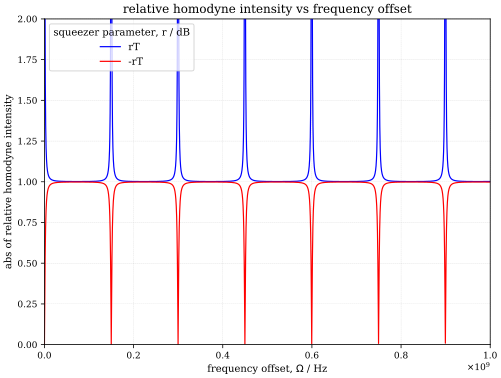

In [19]:
xax = k1[0].x

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(xax, k4[1], label="rT")
ax.plot(xax, k1[1], label="-rT")
# ax.legend(*map(reversed, ax.get_legend_handles_labels()))
ax.legend(title="squeezer parameter, r / dB", loc="upper left")
ax.set(title="relative homodyne intensity vs frequency offset",
       xlabel="frequency offset, $\Omega$ / Hz", ylabel="abs of relative homodyne intensity",
       ylim=(0, 2))
plt.show()

# values may not appear to diverge, however this comes down to choice of datapoints

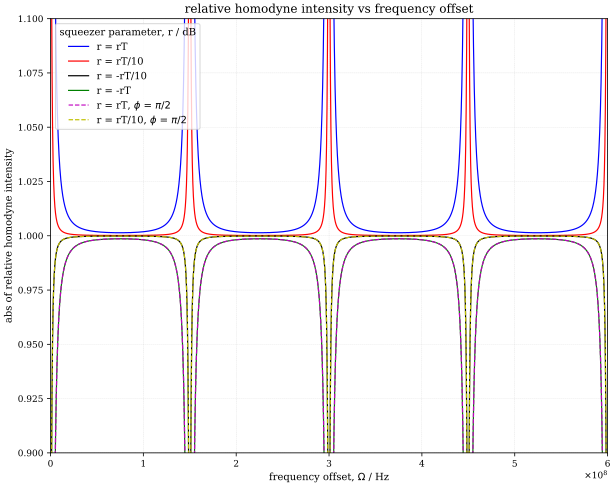

In [20]:
xax = k1[0].x

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(xax, k4[1], label="r = rT")
ax.plot(xax, k3[1], label="r = rT/{}".format(r23scaling))
ax.plot(xax, k2[1], label="r = -rT/{}".format(r23scaling))
ax.plot(xax, k1[1], label="r = -rT")
ax.plot(xax, nk1[1], label="r = rT, $\phi$ = $\pi/2$", linestyle="--", color="m")
ax.plot(xax, nk2[1], label="r = rT/{}, $\phi$ = $\pi/2$".format(r23scaling), linestyle="--", color="y")
# ax.legend(*map(reversed, ax.get_legend_handles_labels()))
ax.legend(title="squeezer parameter, r / dB", loc="upper left")
ax.set(title="relative homodyne intensity vs frequency offset",
       xlabel="frequency offset, $\Omega$ / Hz", ylabel="abs of relative homodyne intensity",
       xlim=(0,0.6e9), ylim=(0.9, 1.1))
fig.savefig("pykat_relative_qhd_vs_freq.pdf")
plt.show()

In [21]:
# comparing threshold squeezer parameters in dB
print(10*np.log10(np.exp(0.026)),rT)

0.11291656529484516 0.1144


In [22]:
# comparing FSR's, frequency vs angular frequency
print(3e8/2*1e-9,0.15*2*np.pi)

0.15000000000000002 0.9424777960769379


In [23]:
# kat2 = deepcopy(kat1)

# kat2code = """
# xaxis nle1 phi lin -180 180 10000 # to spot threshold
# """

# kat2.parse(kat2code)

# out2 = kat2.run()
# out2.plot()

In [24]:
def test_finesse(gaindB):
    """gain in dB"""

    # Vaishali's test code to check nle installed
    #gaindB = 10

    testkat = finesse.kat()
    testkat.verbose = False
    testcode = """
    l l1 1 0 0 n1
    bs bs1 0.5 0.5 0 0 n1 n2 n3 n4

    s s0 1 ni na
    nle nle1 {} 90 na nb
    s s1 1 nb n4

    qhd qn 180 n2 n3
    fsig noise 1

    xaxis noise f lin 1 10G 10000
    """.format(gaindB)
    testkat.parse(testcode)

    out = testkat.run()
    # print(out.stdout)    



    # as above, but with null squeezer (r = 0)
    testkat2 = finesse.kat()
    testkat2.verbose = False
    testcode2 = """
    l l1 1 0 0 n1
    bs bs1 0.5 0.5 0 0 n1 n2 n3 n4

    s s0 1 ni na
    nle nle1 0 0 na nb
    s s1 1 nb n4

    qhd qn 180 n2 n3
    fsig noise 1

    xaxis noise f lin 1 10G 10000
    """
    testkat2.parse(testcode2)

    out2 = testkat2.run()
    # print(out.stdout)    


    # out.plot()
    # out2.plot()

    print("squeezing in dB", gaindB)

    print("squeezing parameter", gain_in_dB_to_r(gaindB))

    plt.plot(out.x, 10*np.log10(out.y/out2.y))
    plt.show()

squeezing in dB 10
squeezing parameter 2.302585092994046


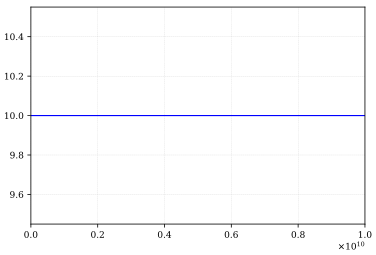

In [25]:
test_finesse(10)

squeezing in dB 3
squeezing parameter 0.6907755278982136


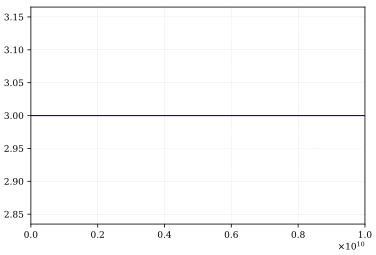

In [26]:
test_finesse(3)